# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [83]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn-v0_8')

### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [84]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [85]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [86]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

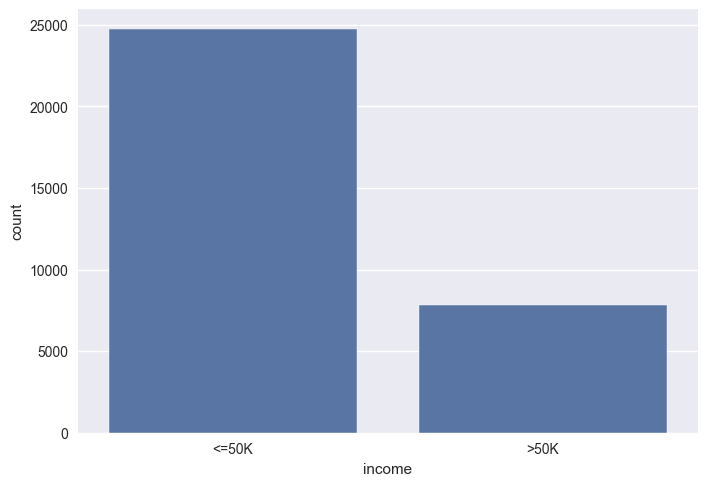

In [87]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [88]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [89]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

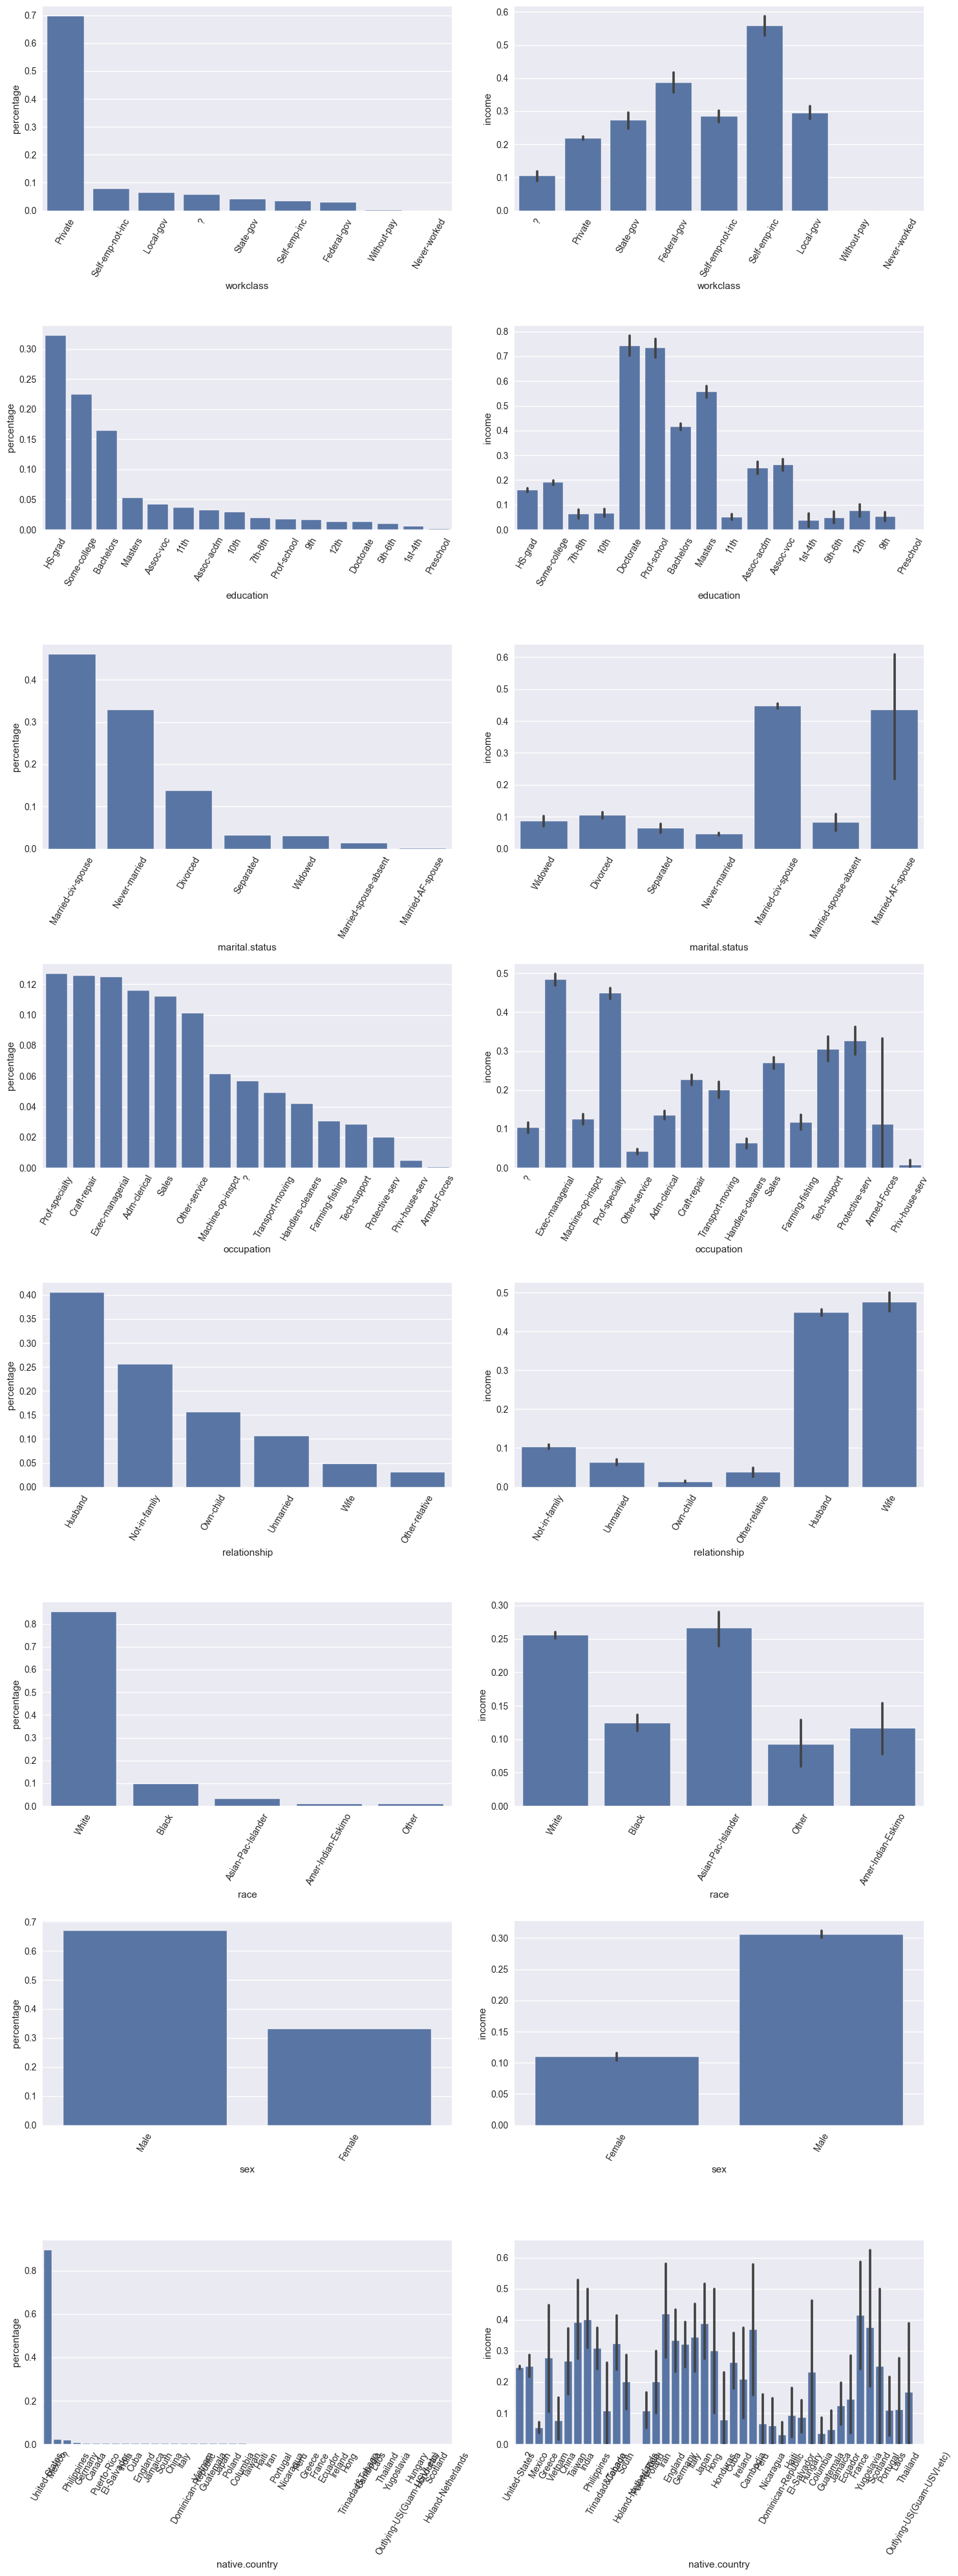

In [90]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True).sort_values(ascending=False).rename('percentage').reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [91]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [92]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [93]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [94]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

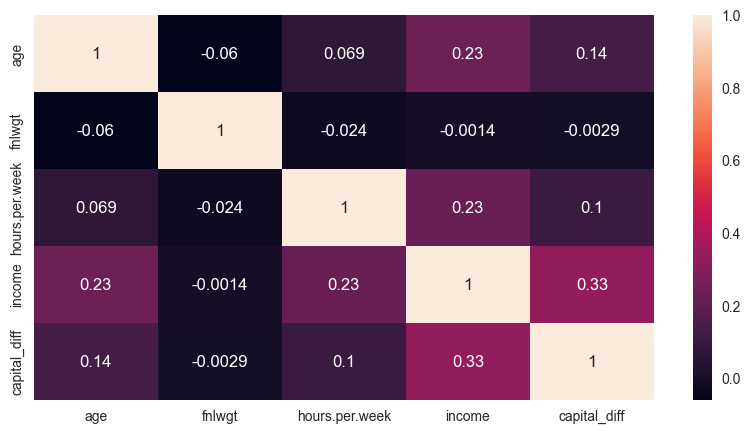

In [95]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(numeric_only=True), annot = True);

Кодируем текстовые категориальные признаки

In [96]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
1,82,11.797134,18,0,8.379539,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
2,66,12.133835,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
3,54,11.851966,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
4,41,12.486216,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [97]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [99]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [100]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


А теперь попробуем подобрать оптимальыне параметры с помощью поиска по стеке.

### GridSearchCV

In [101]:
### Импортируем библиотеку
from sklearn.model_selection import GridSearchCV


In [102]:
### Указываем искомые гиперпараметры в виде словаря
param_grid = {'penalty': ['l2', 'none'], #тип регулфризации
              'solver': ['lbfgs', 'saga'] #алгоритм
              }

Вызвать класс GridSearchCV и передать модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, и n_jobs = -1, чтобы использовать все доступные ядра для расчётов

In [103]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        #Генератор случайных чисел 
        random_state=1,
        #Количество итераций на сходимость 
        max_iter=1000
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

In [104]:
grid_search.fit(X_train_scaled, y_train)

c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 469, in _validate_params
    validate_parameter_constraints(
  File "c:\Program Files (x86)\P

,estimator,LogisticRegre...andom_state=1)
,param_grid,"{'penalty': ['l2', 'none'], 'solver': ['lbfgs', 'saga']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всём обучающем наборе данных с использованием параметров, которые дают наилучшее значение метрики при кросс-валидации.

Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте best_params_

In [105]:
print('Наилучшие значения параметров: {}'.format(grid_search.best_params_))

Наилучшие значения параметров: {'penalty': 'l2', 'solver': 'saga'}


Наилучшая метрика

In [106]:
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.84


Либо можем посмотреть любую другую метрику, воспользовавшись методом predict() и передав предсказанные значения в функцию для расчёта метрики (например, f1_score())

In [107]:
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.64


Попробуем расширить сетку гиперпараметров и проделаем те же шаги

In [108]:
param_grid = [
    {'penalty': ['l2', 'none'], #тип регуляризации
     'solver': ['lbfgs', 'sag'], #алгоритм оптимизации
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, #уровень силы регуляризации
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear', 'saga'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# %time - замеряем время
%time grid_search_1.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_1.score(X_train_scaled, y_train)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_1.best_params_))

c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 469, in _validate_params
    validate_parameter_constraints(
  File "c:\Program Files (x86)

CPU times: total: 1.2 s
Wall time: 12.2 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.9, 'penalty': 'l2', 'solver': 'lbfgs'}


Итоговая модель хранится в параметре best_estimator_, ей можно воспользоваться для получения прогнозов на новых данных

In [109]:
print('Наилучшая модель: \n{}'.format(grid_search.best_estimator_))


Наилучшая модель: 
LogisticRegression(max_iter=1000, random_state=1, solver='saga')


А наилучшее значение метрики на кросс-валидации (значение метрики, усреднённое по всем разбиениям для данной комбинации гиперпараметров) хранится в атрибуте best_score_

In [110]:
print('Наилучшее значение точности при кросс-валидации: {:.2f}'.format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидации: 0.84


Результаты кросс-валидации хранятся в параметре cv_results_. Отрисуем, как менялась метрика при различных гиперпараметрах

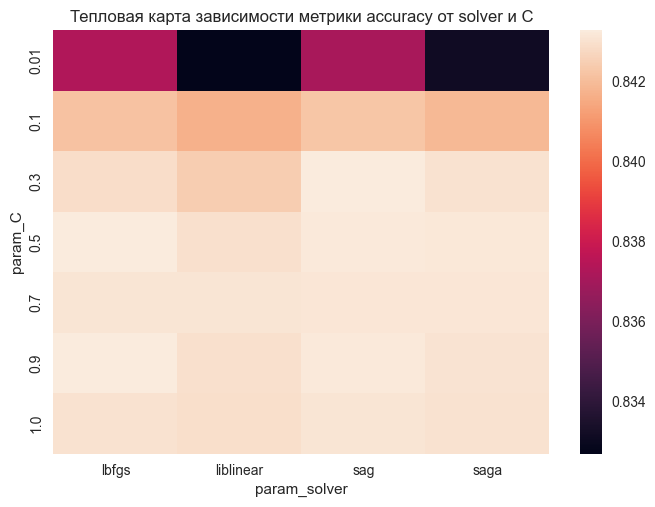

In [111]:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
#Подпись графика
plt.title('Тепловая карта зависимости метрики accuracy от solver и C')
#Задаем размер графика
sns.set(rc={'figure.figsize': (12, 8)})

### RandomizedSearchCV

Начнем с импорта класса из библиотеки

In [112]:
from sklearn.model_selection import RandomizedSearchCV
#np.linspace(start(от), stop(до), num=50(количество), dtype - тип данных)
param_distributions = {'penalty': ['l2', 'none'],
                       'solver': ['lbfgs', 'sag'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float))}

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs= -1
)

%time random_search.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(random_search.score(X_test_scaled, y_test)))

y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))



c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 469, in _validate_params
    validate_parameter_constraints(
  File "c:\Program Files (x86)\P

CPU times: total: 422 ms
Wall time: 7.11 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.45}


Зададим аналогичную сетку, проделаем то же с помощью GridSearchCV и сравним

In [113]:
from sklearn.model_selection import GridSearchCV
#np.linspace(start(от), stop(до), num=50(количество), dtype - тип данных)
param_grid = {'penalty': ['l2', 'none'],
                       'solver': ['lbfgs', 'sag'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float))}

grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs= -1
)

%time grid_search_2.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_2.score(X_test_scaled, y_test)))

y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))

c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Program Files (x86)\Python\Lib\site-packages\sklearn\base.py", line 469, in _validate_params
    validate_parameter_constraints(
  File "c:\Program Files (x86)

CPU times: total: 781 ms
Wall time: 5.06 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.45}


Проделаем аналогичное для DecisionTreeClassifier(). Сначала посчитаем модель с параметрами по умолчанию и оценим метрику

In [114]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:

* 'min_samples_leaf' — минимальное количество объектов в листе;
* 'max_depth' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
* 'criterion' — критерий информативности.

И посчитаем RandomizedSearchCV() и GridSearchCV()

In [ ]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion': ['entropy', 'gini']
              }

random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5, 
    n_iter=50,
    n_jobs=-1
)
%time random_search_tree.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(random_search_tree.score(X_test_scaled, y_test)))

y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_tree.best_params_))

CPU times: total: 1.28 s
Wall time: 5.89 s
accuracy на тестовом наборе: 0.86
f1_score На тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'min_samples_leaf': 36, 'max_depth': 15, 'criterion': 'entropy'}


In [118]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion': ['entropy', 'gini']
              }

grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1
)
%time grid_search_tree.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_tree.score(X_test_scaled, y_test)))

y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_tree.best_params_))

CPU times: total: 1min 15s
Wall time: 9min 24s
accuracy на тестовом наборе: 0.85
f1_score На тестовом наборе: 0.65
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 39}


Метрику удалось улучшить с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени.

Проделаем аналогичное для RandomForestClassifier. Сначала посчитаем модель с параметрами по умолчанию и оценим метрику

In [119]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.66


Теперь зададим сетку гиперпараметров:

* 'n_estimators' — количество деревьев в лесу, по умолчанию = 100;
* 'min_samples_leaf' — минимальное количество объектов в листе;
* 'max_depth' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение.

Посчитаем RandomizedSearchCV() и GridSearchCV()

In [124]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5, 
    n_iter=10,
    n_jobs=-1
)
%time random_search_forest.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(random_search_forest.score(X_test_scaled, y_test)))

y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_forest.best_params_))

CPU times: total: 2.52 s
Wall time: 24.8 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 35}


In [125]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1
)
%time grid_search_forest.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_forest.score(X_test_scaled, y_test)))

y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_forest.best_params_))

CPU times: total: 3.89 s
Wall time: 1min 26s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 28, 'min_samples_leaf': 5, 'n_estimators': 140}


### Задание 2.10
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 200 с шагом 30
min_samples_leaf = [5, 7]
max_depth = [10, 15, 20, 25]
Используйте RandomizedSearchCV с параметрами cv = 5, n_iter = 10.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [129]:
param_distributions = {'n_estimators': list(np.linspace(100, 200, 30, dtype=int)),
                        'min_samples_leaf': [5, 7],
                        'max_depth': [10, 15, 20, 25] 
                    }

random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5, 
    n_iter=10,
    n_jobs=-1
)
%time random_search_forest.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(random_search_forest.score(X_test_scaled, y_test)))

y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_forest.best_params_))

CPU times: total: 2.89 s
Wall time: 33 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
Наилучшие значения гиперпараметров: {'n_estimators': 117, 'min_samples_leaf': 5, 'max_depth': 25}


### Задание 2.11
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 200 с шагом 30
min_samples_leaf = [5, 7]
max_depth = [10, 15, 20, 25]
Используйте GridSearchCV с параметрами cv = 5.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Внимание! Оптимизация может занять много времени.

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [130]:
param_grid = {'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25],
              'n_estimators': list(np.linspace(100, 200, 30, dtype=int))
              }

grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1
)
%time grid_search_forest.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_forest.score(X_test_scaled, y_test)))

y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_forest.best_params_))

CPU times: total: 9.91 s
Wall time: 9min 24s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 103}
